**Predicción de Popularidad de la Música**

Este proyecto usa Machine Learning para predecir la popularidad de canciones según sus características de audio y metadatos. Se aplican técnicas de regresión para estimar reproducciones, descargas y posiciones en listas de éxitos. Se usa un dataset con 227 canciones, incluyendo atributos como nombre, artista, álbum y fecha de lanzamiento. Esto ayuda a plataformas de streaming y artistas a optimizar recomendaciones y estrategias de mercado.

In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
spotify_data = pd.read_csv('/content/drive/MyDrive/colab/Spotify_data.csv')

In [4]:
print(spotify_data.head())

   Unnamed: 0                  Track Name  \
0           0                 Not Like Us   
1           1                     Houdini   
2           2  BAND4BAND (feat. Lil Baby)   
3           3          I Don't Wanna Wait   
4           4                       Pedro   

                                   Artists                  Album Name  \
0                           Kendrick Lamar                 Not Like Us   
1                                   Eminem                     Houdini   
2                    Central Cee, Lil Baby  BAND4BAND (feat. Lil Baby)   
3                David Guetta, OneRepublic          I Don't Wanna Wait   
4  Jaxomy, Agatino Romero, Raffaella Carrà                       Pedro   

                 Album ID                Track ID  Popularity Release Date  \
0  5JjnoGJyOxfSZUZtk2rRwZ  6AI3ezQ4o3HUoP6Dhudph3          96   2024-05-04   
1  6Xuu2z00jxRPZei4IJ9neK  2HYFX63wP3otVIvopRS99Z          94   2024-05-31   
2  4AzPr5SUpNF553eC1d3aRy  7iabz12vAuVQYyekFIWJxD 

In [5]:
# Eliminar columna sin nombre

spotify_data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Información de las columnas

spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        227 non-null    object 
 1   Artists           227 non-null    object 
 2   Album Name        227 non-null    object 
 3   Album ID          227 non-null    object 
 4   Track ID          227 non-null    object 
 5   Popularity        227 non-null    int64  
 6   Release Date      227 non-null    object 
 7   Duration (ms)     227 non-null    int64  
 8   Explicit          227 non-null    bool   
 9   External URLs     227 non-null    object 
 10  Danceability      227 non-null    float64
 11  Energy            227 non-null    float64
 12  Key               227 non-null    int64  
 13  Loudness          227 non-null    float64
 14  Mode              227 non-null    int64  
 15  Speechiness       227 non-null    float64
 16  Acousticness      227 non-null    float64
 1

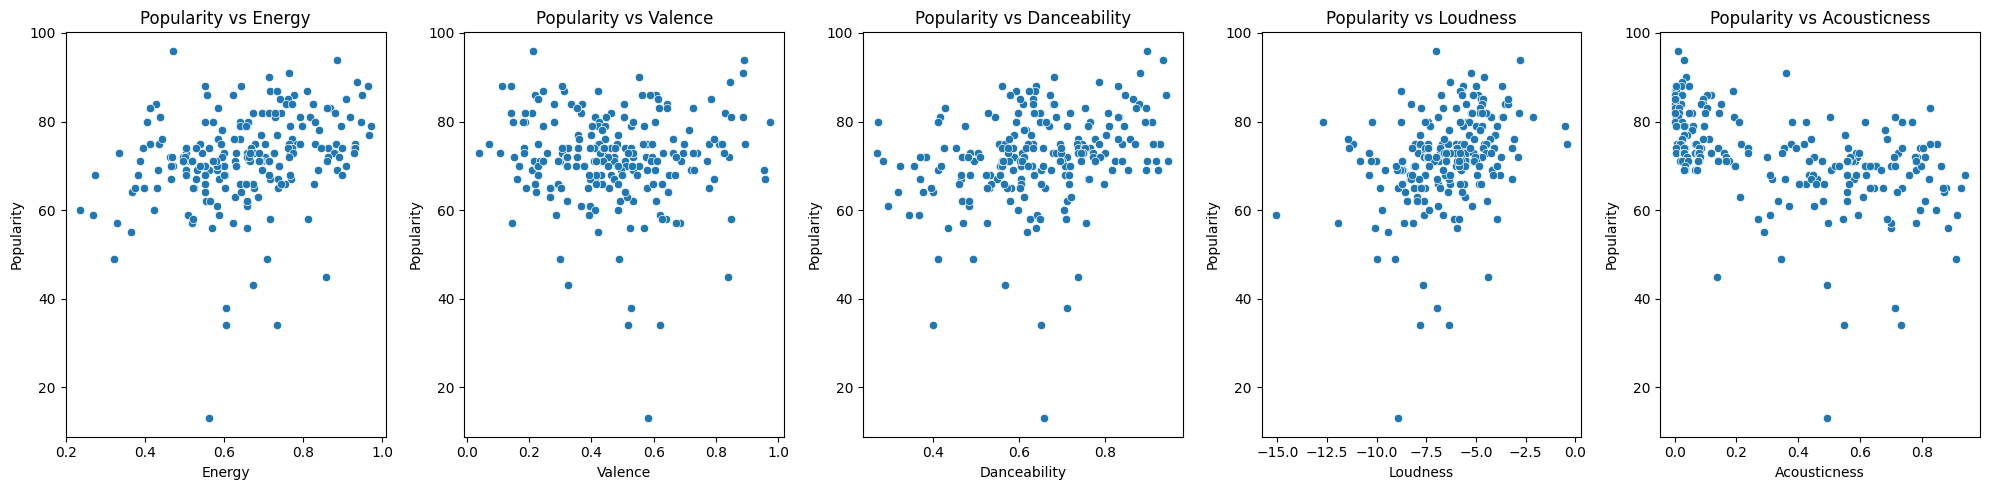

In [7]:
# Análisis exploratorio de datos (EDA)
# La popularidad es la variable objetivo

import matplotlib.pyplot as plt
import seaborn as sns

# Definir características
features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness']

# Crear la figura y los ejes con 1 fila y 5 columnas
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Graficar cada característica
for i, feature in enumerate(features):
    sns.scatterplot(data=spotify_data, x=feature, y='Popularity', ax=axes[i])
    axes[i].set_title(f'Popularity vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Popularity')

# Ajustar diseño
plt.tight_layout()
plt.show()


Las visualizaciones muestran que la energía y la bailabilidad se relacionan positivamente con la popularidad. En cambio, mayor acústica y menor volumen suelen asociarse con menor popularidad. La valencia tiene una relación débil, lo que indica que la positividad emocional no predice bien la popularidad.

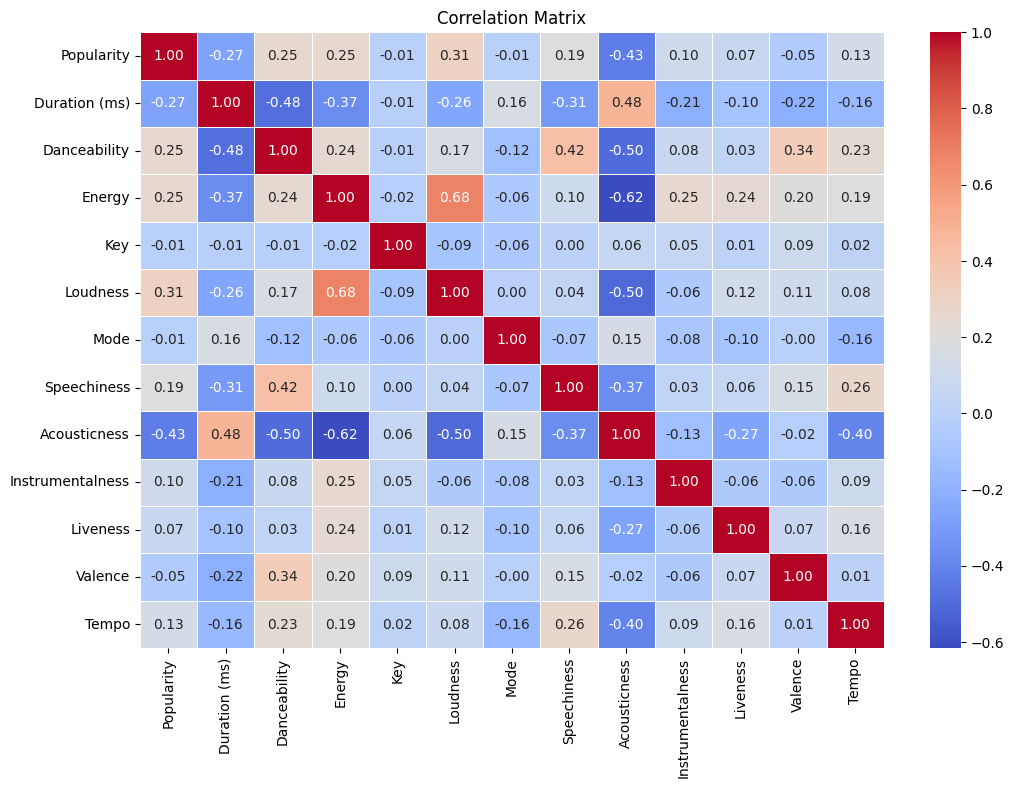

In [8]:
# Correlación

numeric_columns = spotify_data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = spotify_data[numeric_columns]

corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

La popularidad tiene una correlación positiva moderada con el volumen (0.31) y la bailabilidad (0.25), lo que indica que las canciones más ruidosas y bailables tienden a ser más populares. Hay una correlación negativa moderada entre la popularidad y la acústica (-0.43), lo que sugiere que las canciones con mayor acústica suelen ser menos populares. La energía también tiene una correlación positiva con la popularidad (0.25).

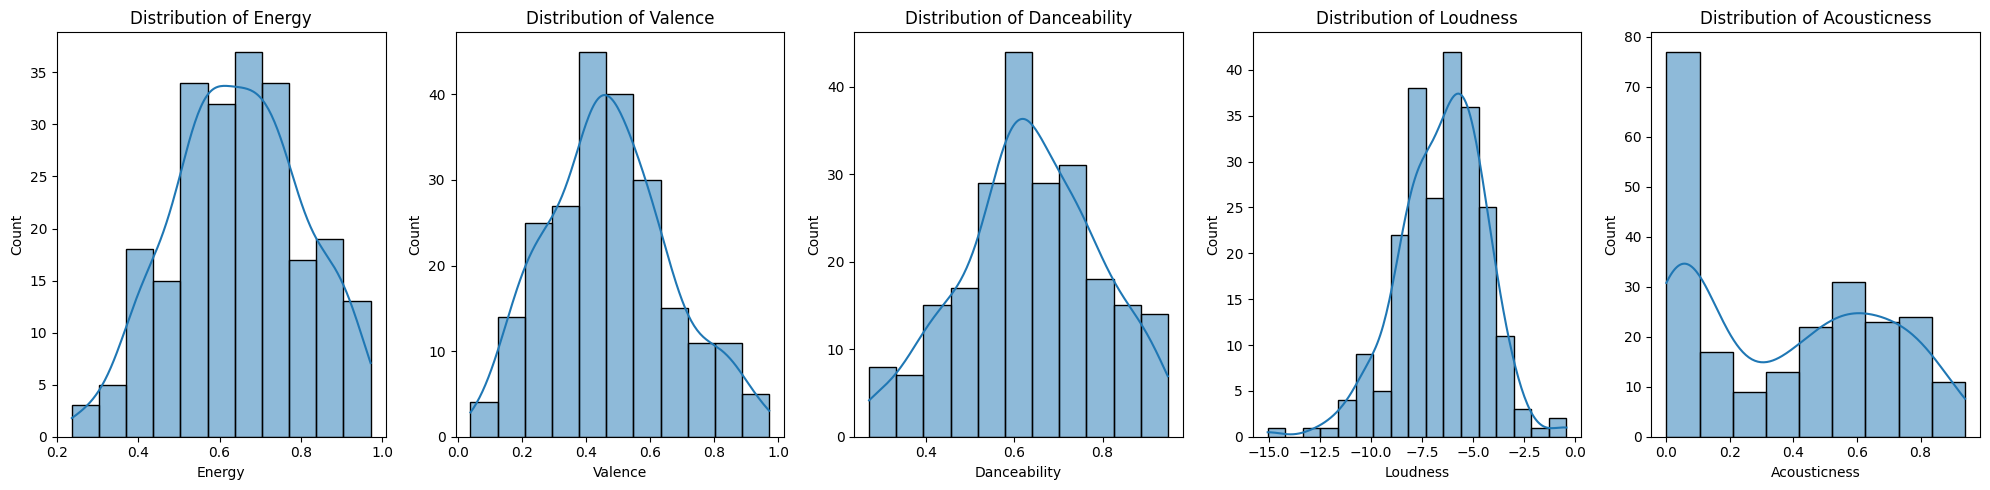

In [9]:
# Distribución

import matplotlib.pyplot as plt
import seaborn as sns

features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, feature in enumerate(features):
    sns.histplot(spotify_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

La energía tiene una distribución en forma de campana, indicando un equilibrio en los niveles de energía. La valencia y la bailabilidad siguen un patrón similar, con la mayoría de las canciones en valores intermedios. El volumen tiene una distribución casi normal centrada en -6 dB, reflejando niveles típicos. En cambio, la acústica está sesgada hacia valores bajos, lo que sugiere que la mayoría de las canciones no son muy acústicas.

In [14]:
# Modelo de predicción

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Variable objetivo y características
features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']
X = spotify_data[features]
y = spotify_data['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                      param_grid, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search_rf.fit(X_train_scaled, y_train)

best_params_rf = random_search_rf.best_params_

best_rf_model = random_search_rf.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)
'''

# Parametrospara Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, refit=True, verbose=2, cv=5)

grid_search_rf.fit(X_train_scaled, y_train)

best_params_rf = grid_search_rf.best_params_

best_rf_model = grid_search_rf.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

print(best_params_rf)
print(best_rf_model)
print(y_pred_best_rf)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; 

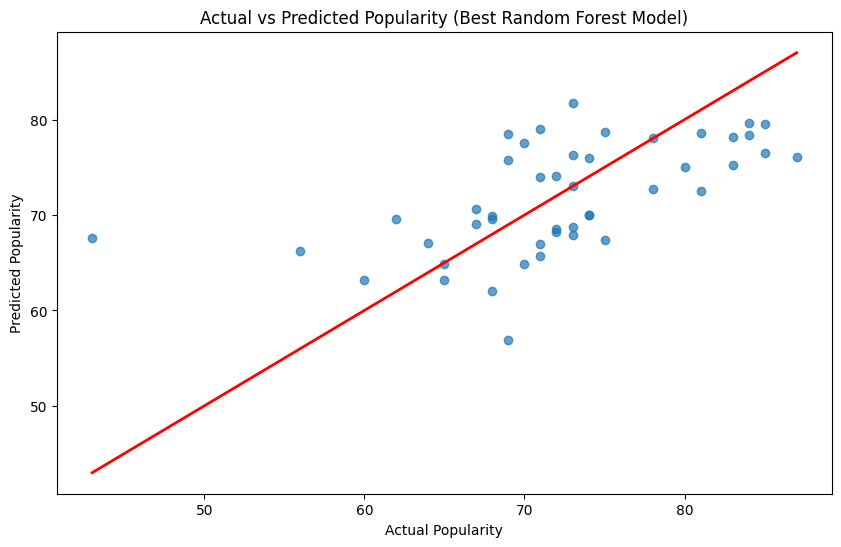

In [15]:
# Predicciones

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity (Best Random Forest Model)')
plt.show()

La línea roja representa predicciones perfectas, donde la popularidad predicha coincidiría exactamente con la popularidad real. La mayoría de los puntos están agrupados alrededor de esta línea, lo que indica que el modelo hace predicciones razonablemente precisas. Sin embargo, hay algunas desviaciones, especialmente en valores de popularidad más bajos, lo que sugiere áreas donde las predicciones del modelo son menos precisas.